all exercises based on [Deep Learning for NLP](https://wikidocs.net/22644)

### 1. 영어 Word2Vec 만들기

In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gpwl0\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import urllib.request
import zipfile
from lxml import etree
import re
from nltk.tokenize import word_tokenize, sent_tokenize

#### 1_훈련데이터 이해 및 전처리

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/GaoleMeng/RNN-and-FFNN-textClassification/master/ted_en-20160408.xml", filename = "ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x2ae564fd2b0>)

In [4]:
# xml 데이터 전처리
targetXML=open('ted_en-20160408.xml', 'r', encoding = 'UTF8')
target_text = etree.parse(targetXML)

# <content>와 </content> 사이의 내용만 가져올 것
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규표현식 sub 모듈로 content 중간에 등장하는 (Audio), (Laughter) 등 배경음 제거
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해 NLTK를 이용해 문장 토큰화 수행
sent_text = sent_tokenize(content_text)

# 각 문장에 대해 구두점 제거, 소문자화
normalized_text = []
for string in sent_text:
    tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
    normalized_text.append(tokens)

# 각 문장에 대해 NLTK 사용해 단어 토큰화 수행
result = [word_tokenize(sentence) for sentence in normalized_text]

In [5]:
print('총 샘플 개수: {}'.format(len(result)))

총 샘플 개수: 273424


In [6]:
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


#### 2_Word2Vec 훈련

In [7]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = result, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [8]:
model_result = model.wv.most_similar('man') # 유사한 단어 출력
print(model_result)

[('guy', 0.8406854867935181), ('woman', 0.8383045196533203), ('lady', 0.7806963920593262), ('boy', 0.764503002166748), ('girl', 0.7480916380882263), ('gentleman', 0.7178901433944702), ('kid', 0.7142511606216431), ('poet', 0.7140650749206543), ('soldier', 0.7064902186393738), ('surgeon', 0.670225977897644)]


#### 3_Word2Vec 모델 저장 및 로드

In [9]:
from gensim.models import KeyedVectors
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format('eng_w2v') # 모델 로드

In [10]:
# 로드한 모델로 most_similar 확인하면 아까와 결과 같음
model_result = loaded_model.most_similar('man')
print(model_result)

[('guy', 0.8406854867935181), ('woman', 0.8383045196533203), ('lady', 0.7806963920593262), ('boy', 0.764503002166748), ('girl', 0.7480916380882263), ('gentleman', 0.7178901433944702), ('kid', 0.7142511606216431), ('poet', 0.7140650749206543), ('soldier', 0.7064902186393738), ('surgeon', 0.670225977897644)]


### 2. 한국어 Word2Vec 만들기 (네이버 영화 리뷰)

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [12]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename = 'ratings.txt')

('ratings.txt', <http.client.HTTPMessage at 0x2aebe6d11d0>)

In [13]:
train_data = pd.read_table('ratings.txt')

In [14]:
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [15]:
print(len(train_data))

200000


In [16]:
train_data.isnull().sum()

id          0
document    8
label       0
dtype: int64

In [17]:
train_data = train_data.dropna(how='any') # null값이 존재하는 행 제거 (비/ 'all'은 전체 데이터가 null인 경우 drop)
print(train_data.isnull().sum())

id          0
document    0
label       0
dtype: int64


In [18]:
len(train_data)

199992

In [19]:
# 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]", "")

In [20]:
train_data[:5]

,id,document,label
0,8112052,어릴때보고지금다시봐도재밌어요ㅋㅋ,1
1,8132799,디자인을배우는학생으로외국디자이너와그들이일군전통을통해발전해가는문화산업이부러웠는데사실우...,1
2,4655635,폴리스스토리시리즈는부터뉴까지버릴께하나도없음최고,1
3,9251303,와연기가진짜개쩔구나지루할거라고생각했는데몰입해서봤다그래이런게진짜영화지,1
4,10067386,안개자욱한밤하늘에떠있는초승달같은영화,1


In [21]:
# 불용어 정의
stopwords = ['의', '가', '이', '은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [26]:
okt = Okt()
tokenized_data = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem = True)
    temp_X = [word for word in temp_X if not word in stopwords]
    tokenized_data.append(temp_X)

리뷰 최대 길이: 68
리뷰 평균 길이: 10.669446777871116


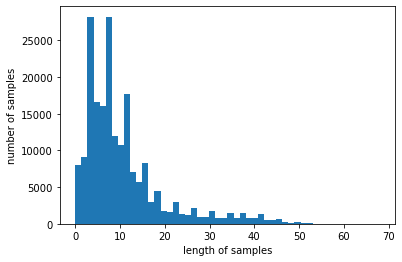

In [27]:
# 리뷰 길이 분포 확인
print('리뷰 최대 길이:', max(len(l) for l in tokenized_data))
print('리뷰 평균 길이:', sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [28]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg= 0)

In [29]:
model.wv.vectors.shape

(17947, 100)

In [30]:
print(model.wv.most_similar('최민식'))

[('이정재', 0.8808534741401672), ('류덕환', 0.879369854927063), ('안성기', 0.878142237663269), ('김수현', 0.872404932975769), ('한석규', 0.8719244003295898), ('설경구', 0.8683328032493591), ('박중훈', 0.8654727935791016), ('김창완', 0.8652353286743164), ('주진모', 0.8471745252609253), ('호프만', 0.8446485996246338)]


In [31]:
print(model.wv.most_similar('히어로'))

[('무협', 0.8635476231575012), ('느와르', 0.8623378276824951), ('블록버스터', 0.8533340692520142), ('호러', 0.8443004488945007), ('물', 0.8401961922645569), ('슬래셔', 0.808931827545166), ('무비', 0.805535078048706), ('정통', 0.8001770973205566), ('액션영화', 0.7975298166275024), ('로코', 0.7928650975227356)]


### 3. 사전 훈련된 Word2Vec 임베딩

#### 1_영어

In [24]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary = True)

In [25]:
print(model.vectors.shape)
# 300만개의 데이터, 300개의 feature(차원)

(3000000, 300)


In [27]:
print(model.similarity('this', 'is'))
print(model.similarity('post', 'book'))

0.40797037
0.057204384


In [28]:
print(model['book']) # 단어 book의 vector

[ 0.11279297 -0.02612305 -0.04492188  0.06982422  0.140625    0.03039551
 -0.04370117  0.24511719  0.08740234 -0.05053711  0.23144531 -0.07470703
  0.21875     0.03466797 -0.14550781  0.05761719  0.00671387 -0.00701904
  0.13183594 -0.25390625  0.14355469 -0.140625   -0.03564453 -0.21289062
 -0.24804688  0.04980469 -0.09082031  0.14453125  0.05712891 -0.10400391
 -0.19628906 -0.20507812 -0.27539062  0.03063965  0.20117188  0.17382812
  0.09130859 -0.10107422  0.22851562 -0.04077148  0.02709961 -0.00106049
  0.02709961  0.34179688 -0.13183594 -0.078125    0.02197266 -0.18847656
 -0.17480469 -0.05566406 -0.20898438  0.04858398 -0.07617188 -0.15625
 -0.05419922  0.01672363 -0.02722168 -0.11132812 -0.03588867 -0.18359375
  0.28710938  0.01757812  0.02185059 -0.05664062 -0.01251221  0.01708984
 -0.21777344 -0.06787109  0.04711914 -0.00668335  0.08544922 -0.02209473
  0.31835938  0.01794434 -0.02246094 -0.03051758 -0.09570312  0.24414062
  0.20507812  0.05419922  0.29101562  0.03637695  0.04

#### 2_한국어

In [29]:
import gensim
model = gensim.models.Word2Vec.load('./ko/ko.bin')

In [30]:
result = model.wv.most_similar('강아지')
print(result)

[('고양이', 0.7290452718734741), ('거위', 0.7185635566711426), ('토끼', 0.7056223154067993), ('멧돼지', 0.6950401067733765), ('엄마', 0.6934334635734558), ('난쟁이', 0.6806551218032837), ('한마리', 0.6770296096801758), ('아가씨', 0.6750352382659912), ('아빠', 0.6729634404182434), ('목걸이', 0.6512460708618164)]
